In [1]:
import numpy as np
from Bio import SeqIO
import os
import pandas as pd
import torch
import seaborn as sns
import math
import scipy.stats as stats
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from numpy import trapz
from sklearn.metrics import auc
from pathlib import Path
sns.set(font_scale=1.8, style="ticks")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/data/rbg/users/wxsh/miniconda3/envs/vaxseer/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runs_folder = Path("../../../runs/cov_countries")
data_folder = Path("../../../data/gisaid/cov/spike_rbd_processed_countries")
saving_dir = Path("figs")

saving_dir.mkdir(parents=True, exist_ok=True)

# NLL & revNLL

In [3]:
testing_window=3
year_and_month_all = ("2021-07", "2021-10","2022-01", "2022-04")
countries="africa/south_africa asia/china asia/india asia/indonesia asia/israel asia/japan asia/south_korea europe/austria europe/belgium europe/czech_republic europe/denmark europe/france europe/germany europe/ireland europe/italy europe/luxembourg europe/netherlands europe/norway europe/poland europe/russia europe/slovenia europe/spain europe/sweden europe/switzerland europe/turkey europe/united_kingdom north_america/canada north_america/mexico north_america/usa oceania/australia south_america/brazil south_america/peru"
locations=countries.split()
def get_nlls(df):
    m = df.pivot(index='src_id', columns='src_time', values='prediction')
    m = torch.tensor(m.to_numpy())
    nlls = - (torch.logsumexp(-m, dim=-1) - math.log(m.size(1))) 
    freqs = torch.tensor(df.pivot(index='src_id', columns='src_time', values='freq').to_numpy())
    if torch.all(torch.isnan(freqs)):
        freqs = torch.ones(freqs.size()) / freqs.size(0)
    freqs = torch.mean(freqs, dim=1)
    freqs = freqs / torch.sum(freqs)
    
    token_num = torch.tensor(df.pivot(index='src_id', columns='src_time', values='token_num').to_numpy()).float()
    assert torch.sum(token_num != torch.mean(token_num, dim=1, keepdims=True)).item() == 0
    token_num = torch.mean(token_num, dim=1)
    nll = torch.sum(freqs * nlls) / torch.sum(freqs * token_num) # average over token number
    return nll

def read_all_nll(path, id2location):
    if isinstance(path, Path):
        if not os.path.exists(path):
            print(path)
            return None
        df = pd.read_csv(path)
        locations = []
        for src_id in df["src_id"]:
            locations.append(id2location[src_id])
        df["location"] = locations
        return df
    elif isinstance(path, dict):
        all_dfs = []
        for location, p in path.items(): 
            df = pd.read_csv(p)
            locations = [location] * len(df)
            df["location"] = locations
            all_dfs.append(df)
        return pd.concat(all_dfs)

time2location_to_count = dict()
id2location = dict()

for year_and_month in year_and_month_all:
    year, month = year_and_month.split("-")
    year = int(year)
    
    testing_index = (year - 2020) * 12 / testing_window + (int(month) + testing_window - 1) / testing_window
    
    total_bin_size=0
    data_bin_size=0
    location_to_count = defaultdict(int)

    all_test_path = data_folder / f"2020-01_to_2023-12_3M/all/human_minBinSize100_minLen223_maxLen223_location_region2_bins/{int(testing_index)}.fasta"
    bin_size=int(next(SeqIO.parse(all_test_path, "fasta")).description.split("bin_size=")[1].split("|")[0])
    data_bin_size+=bin_size

    for record in SeqIO.parse(all_test_path, "fasta"):
        desc = record.description.split()[1].split("|")
        desc = {x.split("=")[0]: x.split("=")[1] for x in desc}
        id2location[record.id] = desc["location"]
        location_to_count[desc["location"]] += round(float(desc["freq"]) * int(desc["bin_size"]))
    print("Total number of seqs:",  data_bin_size, sum(location_to_count.values()))
    time2location_to_count[year_and_month] = location_to_count


Total number of seqs: 2477483 2477484
Total number of seqs: 2933995 2933994
Total number of seqs: 1428917 1428916
Total number of seqs: 1227563 1227562


In [4]:
nll_results = defaultdict(list)

for year_and_month in year_and_month_all:
    print(year_and_month)
    year, month = year_and_month.split("-")
    year = int(year)

    for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
        name2nll_path = {
            "Global": runs_folder / f"2020-01_to_{year_and_month}_1M/global/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
            "Prepend": runs_folder / f"2020-01_to_{year_and_month}_1M/prepend/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
            "Add_Embed": runs_folder / f"2020-01_to_{year_and_month}_1M/concat/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
            "Param_share": runs_folder / f"2020-01_to_{year_and_month}_1M/param_share/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
            "LoRA": {
                location: runs_folder / f"2020-01_to_{year_and_month}_1M/finetune_lora/test_3M/{location.split('/')[0]}_{location.split('/')[1]}/temp_{temperature}/lightning_logs/version_0/test_results.csv" for location in locations
            },
            "Finetune": {
                location: runs_folder / f"2020-01_to_{year_and_month}_1M/finetune/test_3M/{location.split('/')[0]}_{location.split('/')[1]}/temp_{temperature}/lightning_logs/version_0/test_results.csv" for location in locations
            },
            "Transmission(G2G)": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/continent_to_continent/agg_complete_3/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
            "Transmission(G2L)": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/country_to_continent/agg_complete_3/test_3M/temp_{temperature}/lightning_logs/version_0/test_results.csv",
        }
        model2nll = dict()
        for model in name2nll_path:
            model2nll[model] = read_all_nll(name2nll_path[model], id2location)

        for test_rev_dir in ("test_rev_1",  "test_rev_2", "test_rev_3"):
            # print(">>>", test_rev_dir)
            for location in locations:
                continent, country = location.split("/")
                name2rev_nll_path = {
                    "Transmission(G2L)": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/country_to_continent/agg_complete_3/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Transmission(G2G)": runs_folder / f"2020-01_to_{year_and_month}_1M/transmission_hierachy/continent_to_continent/agg_complete_3/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",                                        
                    "Global": runs_folder / f"2020-01_to_{year_and_month}_1M/global/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "LoRA": runs_folder / f"2020-01_to_{year_and_month}_1M/finetune_lora/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Finetune": runs_folder / f"2020-01_to_{year_and_month}_1M/finetune/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Add_Embed": runs_folder / f"2020-01_to_{year_and_month}_1M/concat/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Prepend": runs_folder / f"2020-01_to_{year_and_month}_1M/prepend/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",
                    "Param_share": runs_folder / f"2020-01_to_{year_and_month}_1M/param_share/{test_rev_dir}/{continent}_{country}/temp_{temperature}/lightning_logs/version_0/test_results.csv",

                }

                for name, _path in name2nll_path.items():
                    our_model_path_rev_nll = name2rev_nll_path[name]
                    if os.path.exists(our_model_path_rev_nll) and name in model2nll:
                        df = model2nll[name]
                        nll = get_nlls(df[df["location"] == location])
                        df = pd.read_csv(our_model_path_rev_nll)
                        rev_nll = get_nlls(df)

                        nll_results["NLL"].append(nll.item())
                        nll_results["reverse NLL"].append(rev_nll.item())
                        nll_results["temperature"].append(temperature)
                        nll_results["location"].append(location)
                        nll_results["model"].append(name)
                        nll_results["time"].append(year_and_month)
                        nll_results["bin_size"].append(time2location_to_count[year_and_month][location])
                        nll_results["oracle"].append(test_rev_dir)


                    else:
                        if not os.path.exists(our_model_path_rev_nll):
                            print("cound not find file:", our_model_path_rev_nll)

                        if model not in model2nll:
                            print(model)

nll_results = pd.DataFrame(nll_results)
print(nll_results)
ori_nll_results = nll_results

2021-07
2021-10
2022-01
2022-04
            NLL  reverse NLL  temperature             location  \
0      0.232112     0.011117          0.2  africa/south_africa   
1      0.282388     0.013775          0.2  africa/south_africa   
2      0.352275     0.013988          0.2  africa/south_africa   
3      0.353063     0.014011          0.2  africa/south_africa   
4      0.233468     0.011013          0.2  africa/south_africa   
...         ...          ...          ...                  ...   
15355  0.090466     0.046874          1.0   south_america/peru   
15356  0.066653     0.037834          1.0   south_america/peru   
15357  0.064201     0.038281          1.0   south_america/peru   
15358  0.057404     0.053229          1.0   south_america/peru   
15359  0.055273     0.049955          1.0   south_america/peru   

                   model     time  bin_size      oracle  
0                 Global  2021-07      7999  test_rev_1  
1                Prepend  2021-07      7999  test_rev_1  
2

In [5]:
def get_summary(df, keys=("model", "temperature", "year"), weighted_average=True, worse=False):
    summary_nll_results = defaultdict(list)
    for x in zip(*(df[key] for key in keys)):
        _df = df
        for i, key in enumerate(keys):
            _df = _df[_df[key] == x[i]]
        
        if weighted_average:
            ave_nll = np.sum(_df["bin_size"] * _df["NLL"]) / np.sum(_df["bin_size"])
            ave_rev_nll = np.sum(_df["bin_size"] * _df["reverse NLL"]) / np.sum(_df["bin_size"])
        else:
            ave_nll = np.mean(_df["NLL"])
            ave_rev_nll = np.mean(_df["reverse NLL"])

        if worse:
            ave_nll = np.max(_df["NLL"])
            ave_rev_nll = np.max(_df["reverse NLL"])
        for i, key in enumerate(keys):
            summary_nll_results[key].append(x[i])
        summary_nll_results["nll"].append(ave_nll)
        summary_nll_results["rev_nll"].append(ave_rev_nll)
        summary_nll_results["toal_sample_size"].append(np.sum(_df["bin_size"]))


    summary_nll_results = pd.DataFrame(summary_nll_results)
    summary_nll_results = summary_nll_results.drop_duplicates()
    return summary_nll_results

In [6]:
def plot(summary_summary_df, fig_title, fig_save_path):
    plt.xscale('log')
    plt.yscale('log')

    plt.rcParams['lines.markersize'] = 15
    
    ori_our_model_name_1 = "Transmission(G2G)"
    our_model_name_1 = r'$\bf{Transmission(G2G)}$' # r'$\bf{Bold}$'
    
    ori_our_model_name_2 = "Transmission(G2L)"
    our_model_name_2 = r'$\bf{Transmission(G2L)}$' # r'$\bf{Bold}$'
    
    summary_summary_df["model"] = [
        x if (x != ori_our_model_name_1 and x != ori_our_model_name_2) 
        else r'$\bf{%s}$' % x for x in summary_summary_df["model"]]

    
    models = list(set(summary_summary_df["model"]))
    models.sort()
    print(models)
    style_dict = {}
    for model in models:
        if model == our_model_name_1 or model == our_model_name_2:
            style_dict[model] = ""
        else:
            style_dict[model] = (2,2)
    
    print(style_dict)
    style_order =  [our_model_name_1, our_model_name_2,  'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']
    print(style_order)

    # color dict
    palette_light = sns.color_palette("Set2", n_colors=8) # pastel
    palette_dark = sns.color_palette("hls", n_colors=8)
    color_dict = {}
    
    models.remove(our_model_name_1)
    models.remove(our_model_name_2)
    
    for i, model in enumerate(models):
        color_dict[model] = palette_light[i]
    color_dict[our_model_name_1] = palette_dark[5]
    color_dict[our_model_name_2] = palette_dark[0]

    ax = sns.lineplot(summary_summary_df, x="nll", y="rev_nll", hue="model", markers=True, # marker='o', 
                      sort=False,style="model",lw=2.5, dashes=style_dict,palette=color_dict,style_order=style_order) # , size=20 ,linewidth = 1.5

    
    # ax = sns.lineplot(summary_summary_df, x="nll", y="rev_nll", hue="model", markers=True, # marker='o', 
                      # sort=False,style="model",lw=2.5) # , size=20 ,linewidth = 1.5

    # ax.set_title("%s (average)" % (subtype))
    ax.set_title(fig_title)
    ax.set_xlabel("NLL")
    ax.set_ylabel("reverse NLL")

    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    

    plt.savefig(fig_save_path, format='pdf', bbox_inches='tight')

    plt.show()

In [7]:
min_bin_size = 1000
_nll_results = nll_results[nll_results["bin_size"]>=min_bin_size]
local_summary_df = get_summary(_nll_results, keys=("model", "temperature", "location", "oracle"), weighted_average=False)


asia/china 4341
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


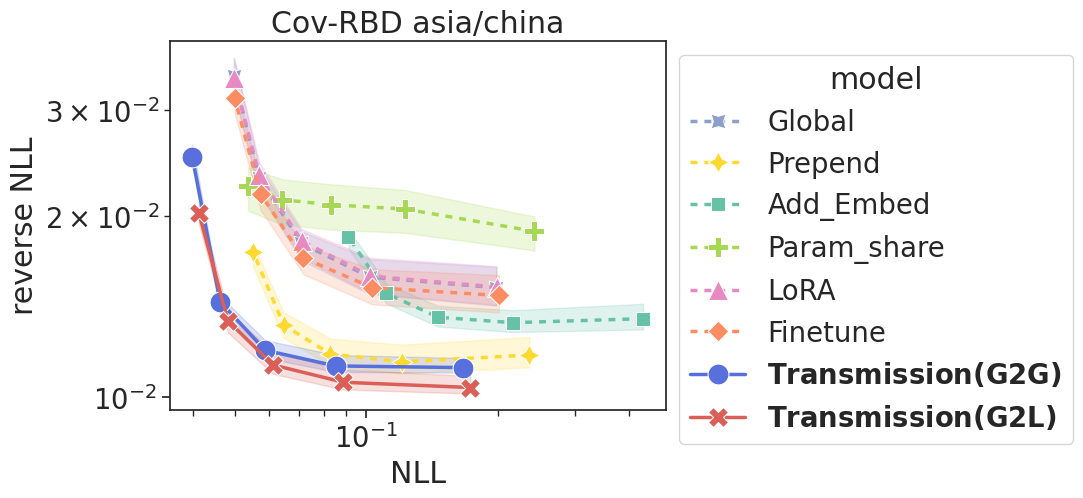

africa/south_africa 21889
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


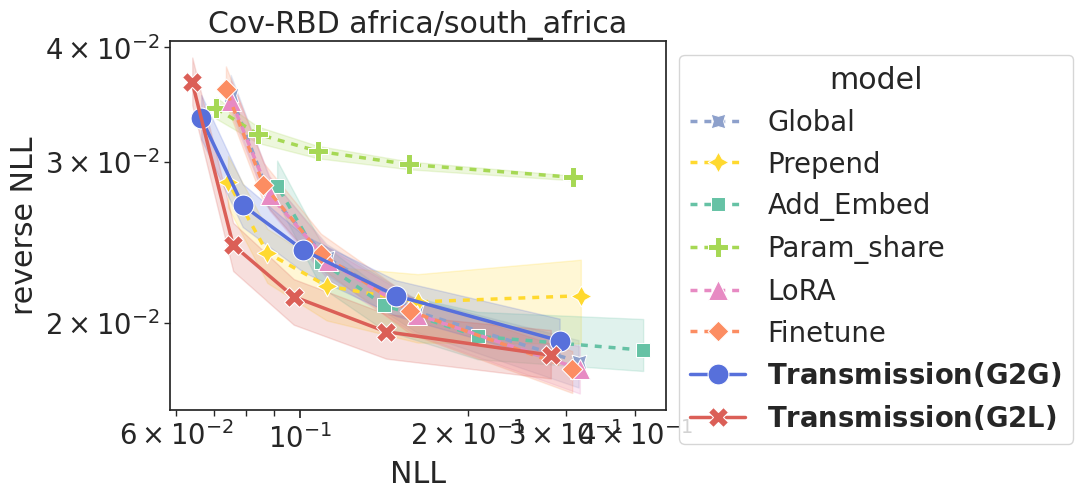

south_america/peru 28065
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


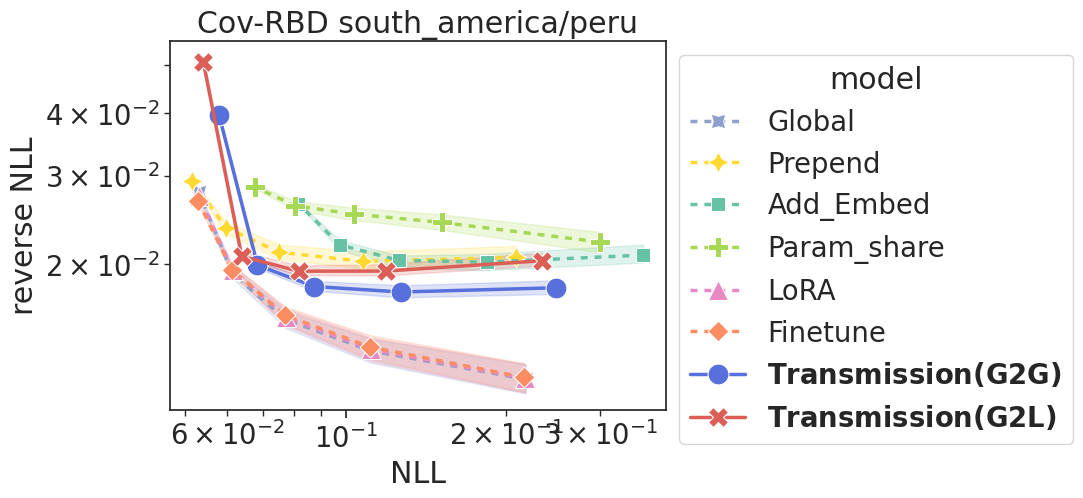

asia/indonesia 28458
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


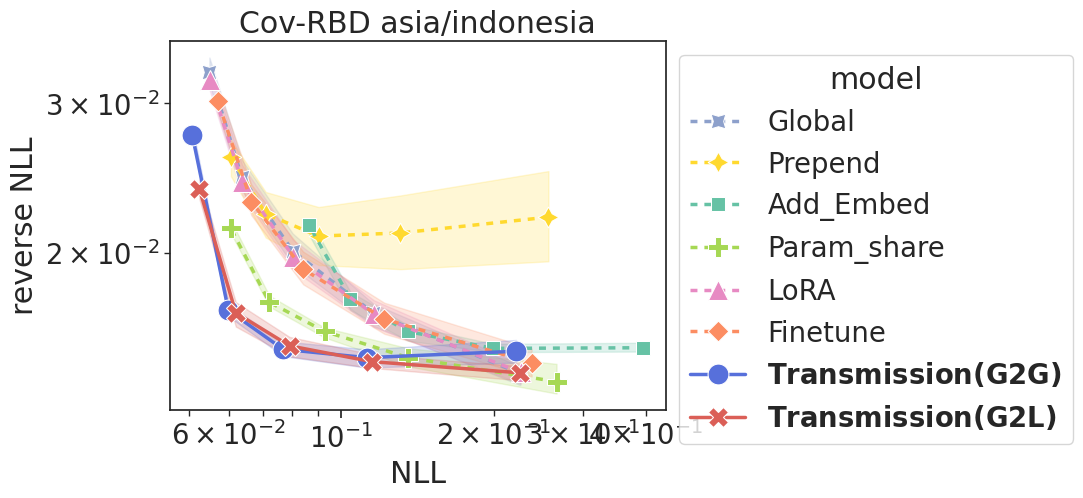

europe/turkey 31330
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


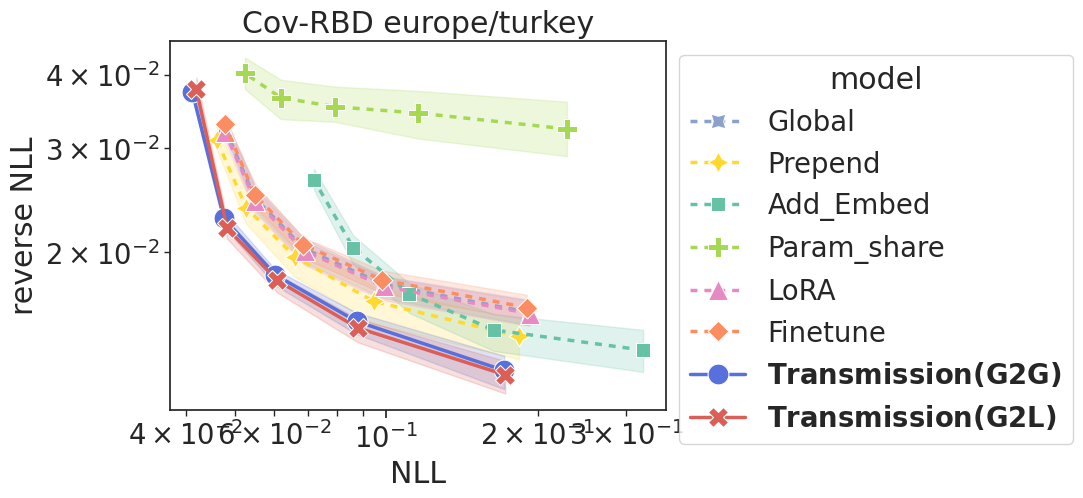

europe/luxembourg 31615
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


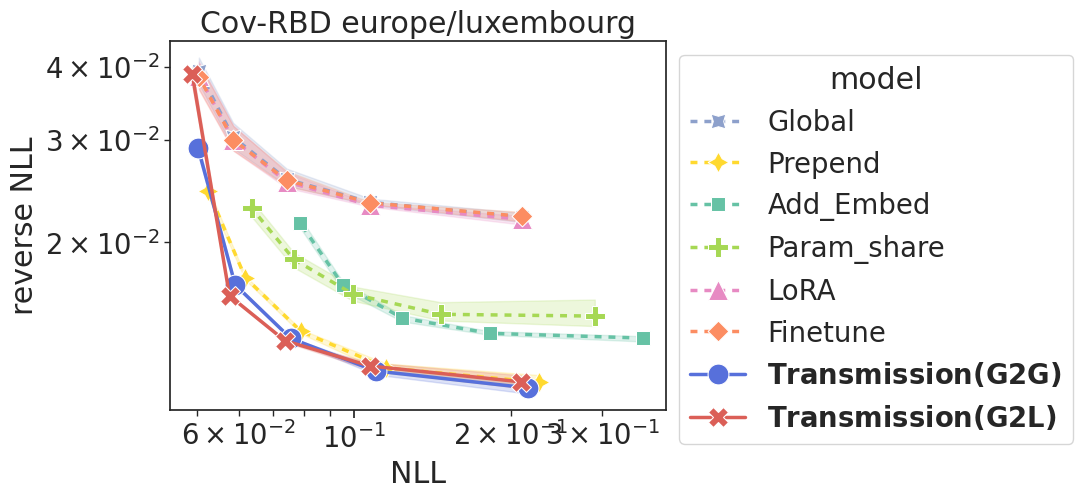

europe/czech_republic 42319
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


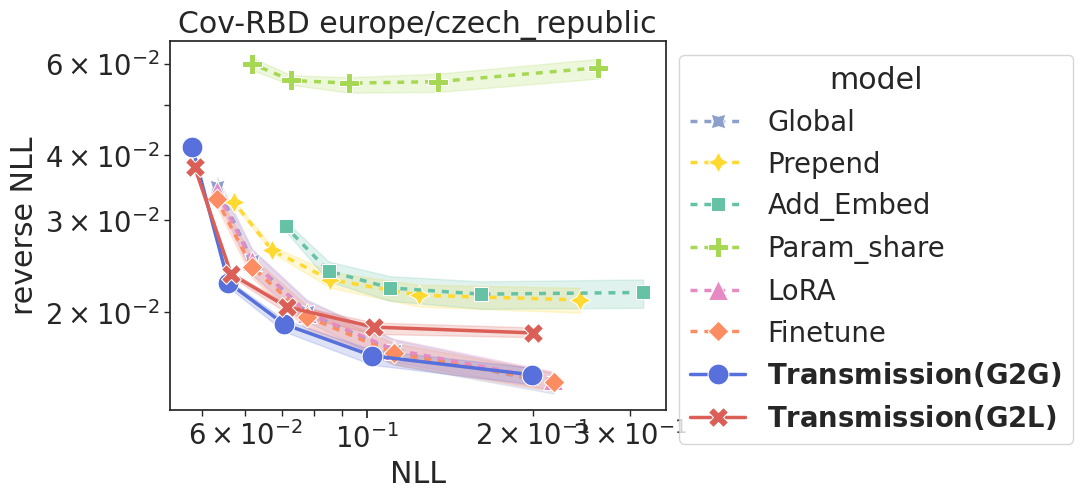

europe/norway 42508
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


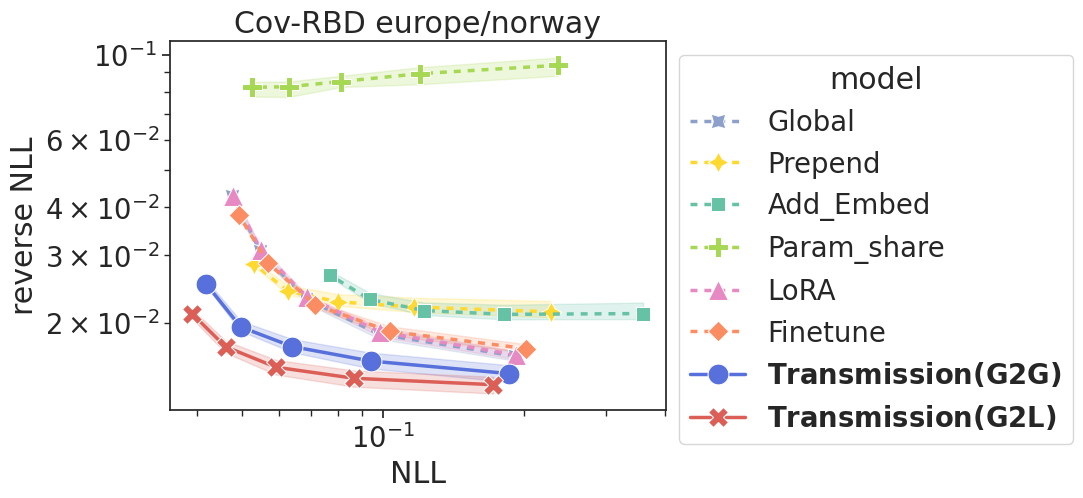

north_america/mexico 44161
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


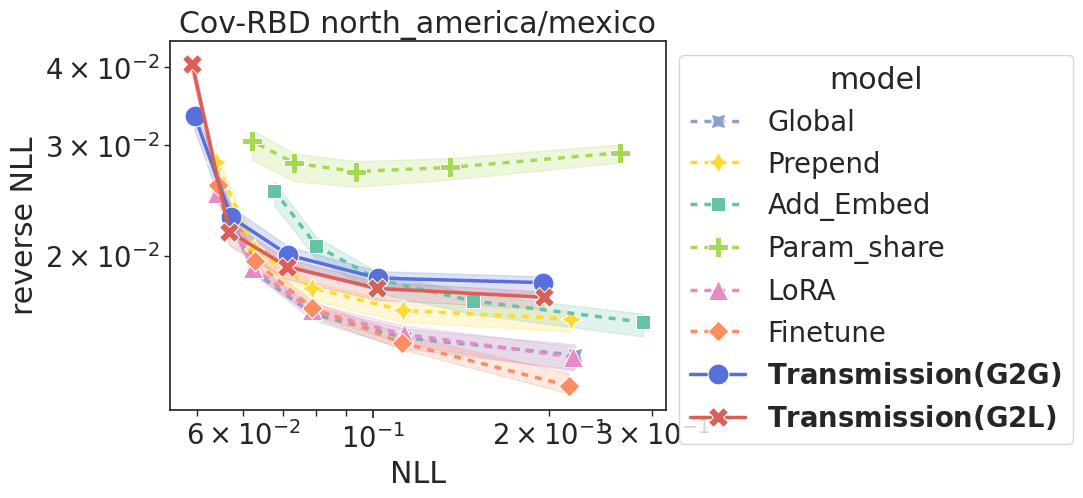

europe/slovenia 44496
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


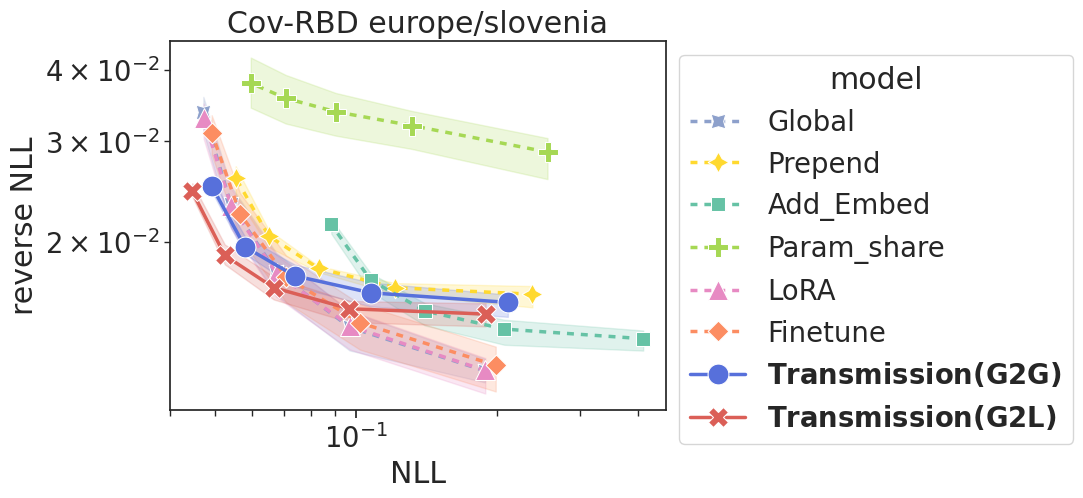

europe/russia 45879
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


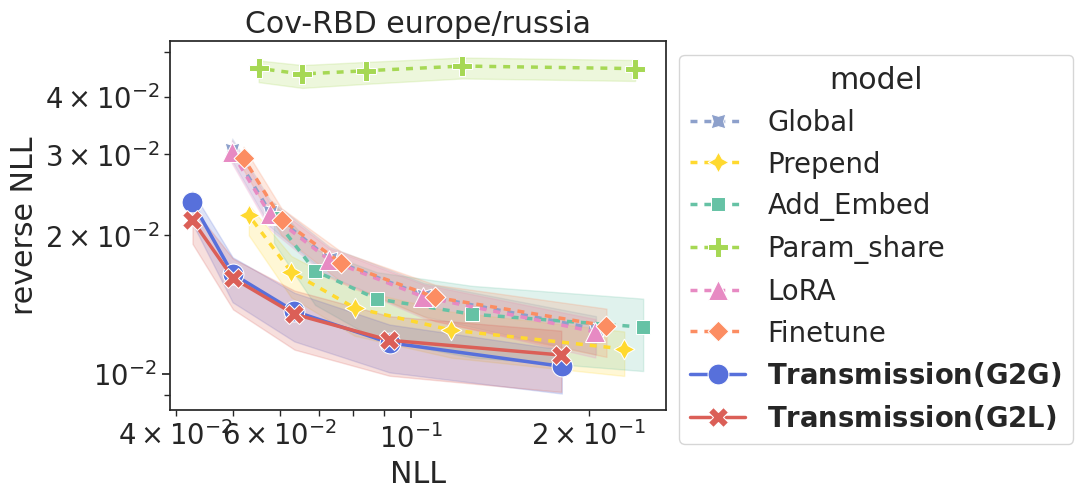

europe/ireland 55327
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


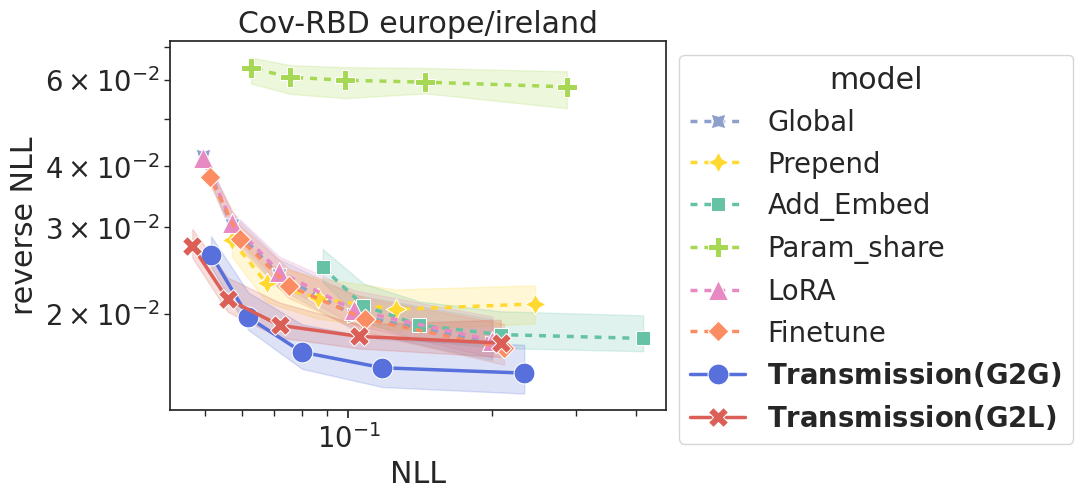

europe/poland 64250
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


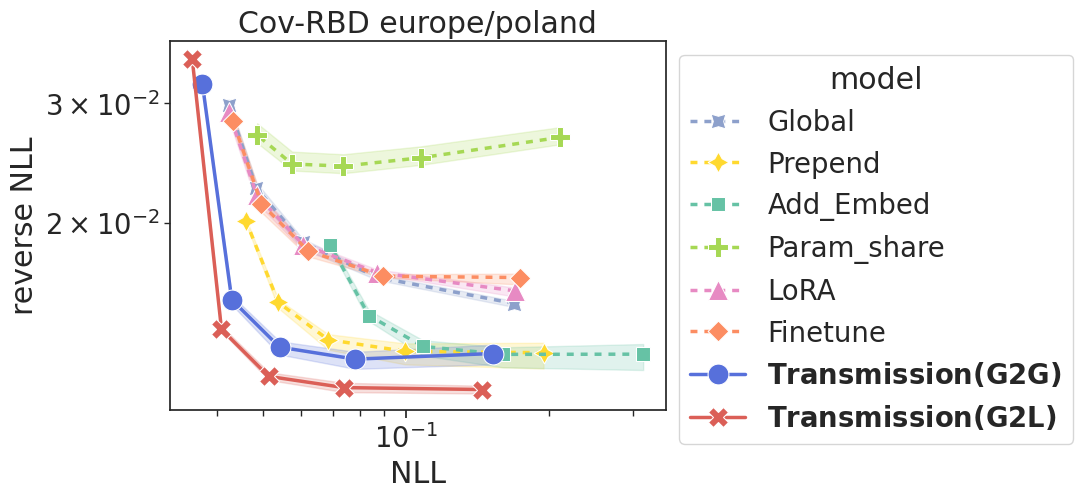

asia/south_korea 72917
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


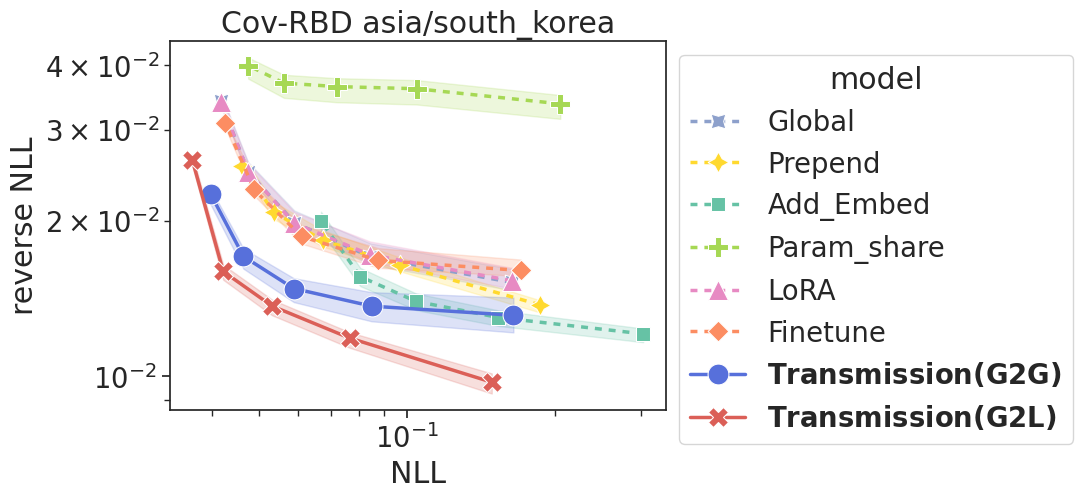

europe/netherlands 75325
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


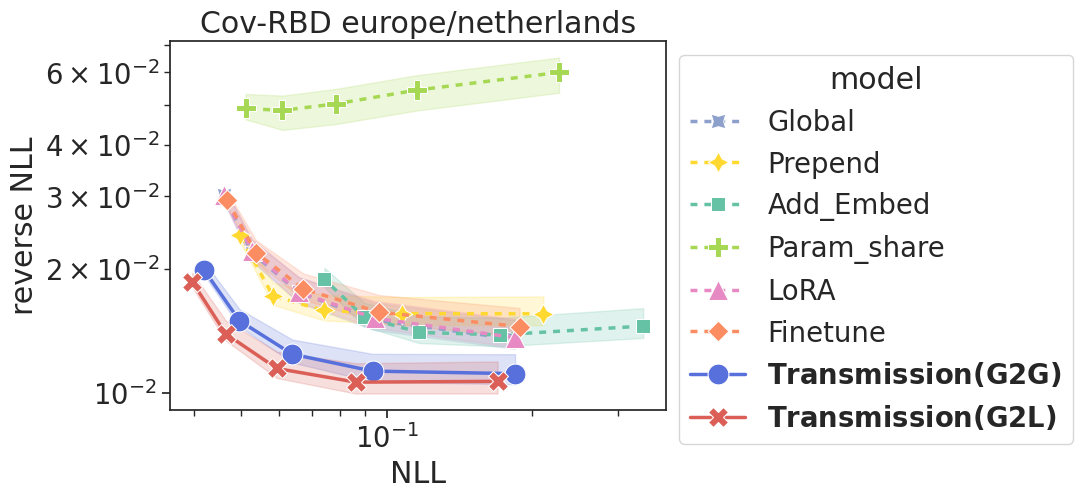

europe/switzerland 77796
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


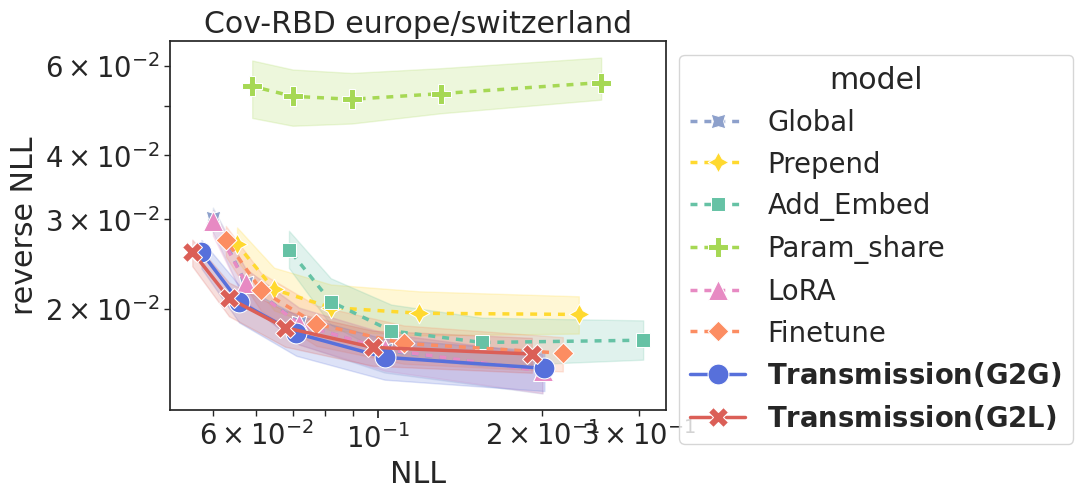

europe/italy 82988
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


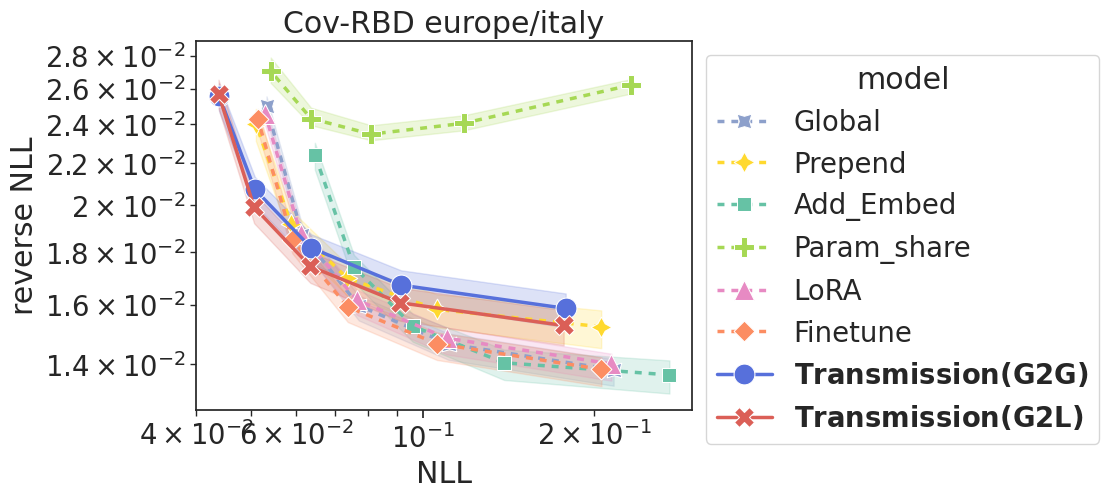

europe/belgium 104696
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


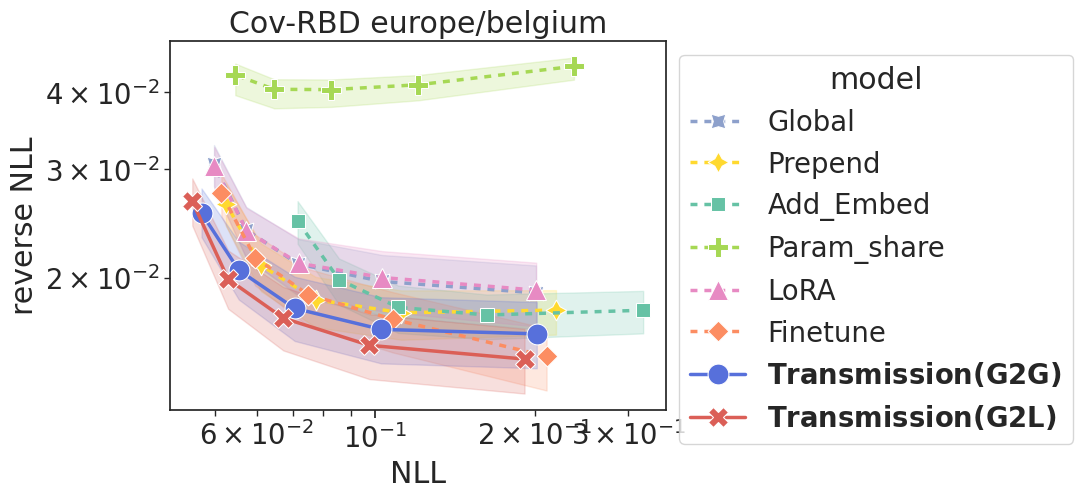

europe/spain 105714
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


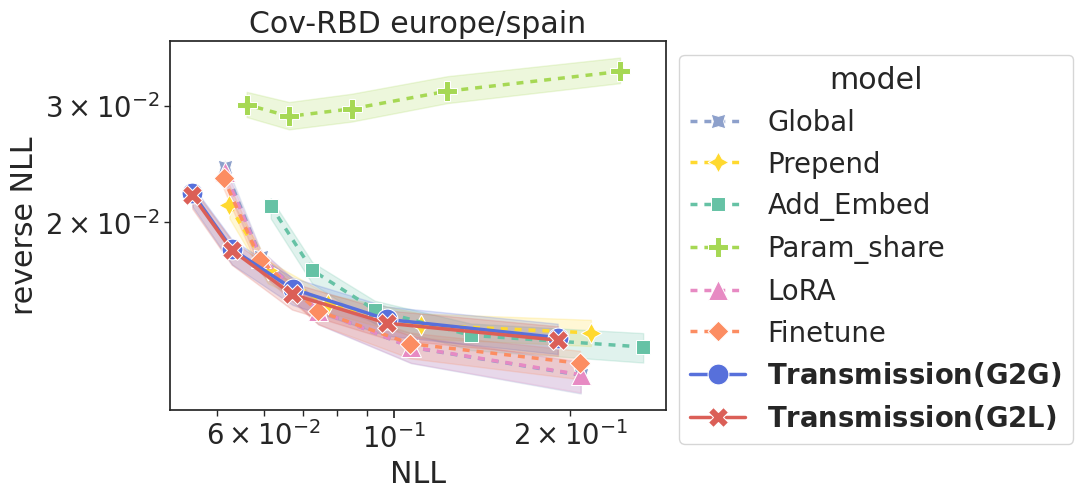

europe/sweden 107503
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


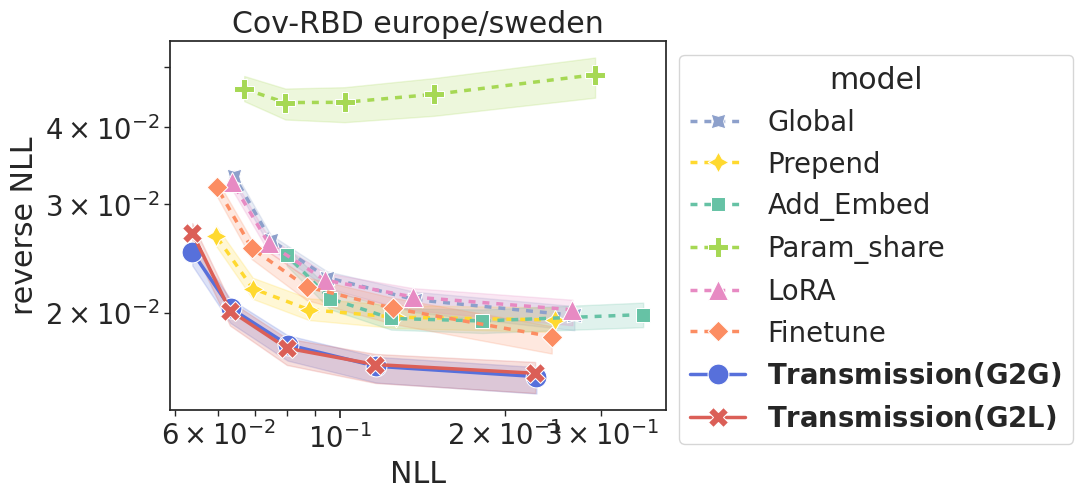

south_america/brazil 112001
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


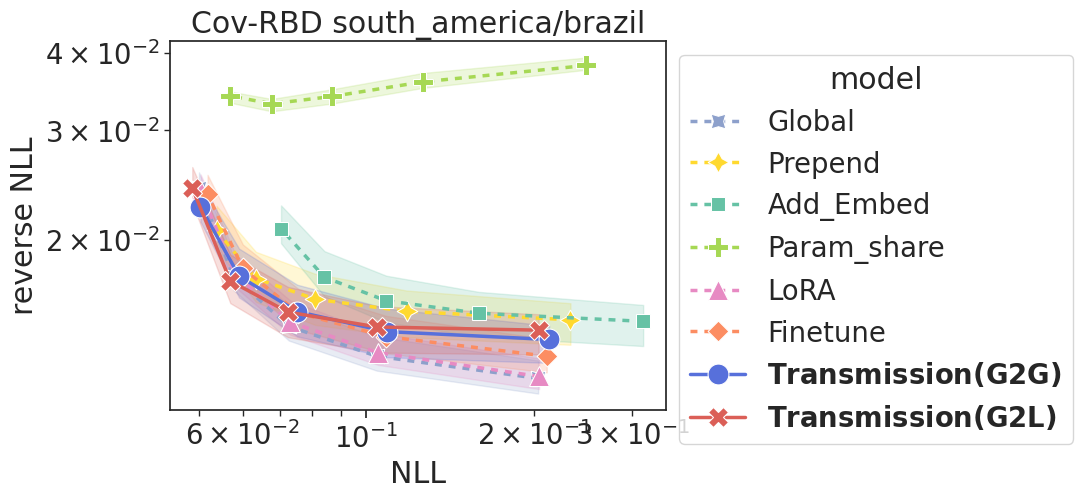

asia/israel 112535
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


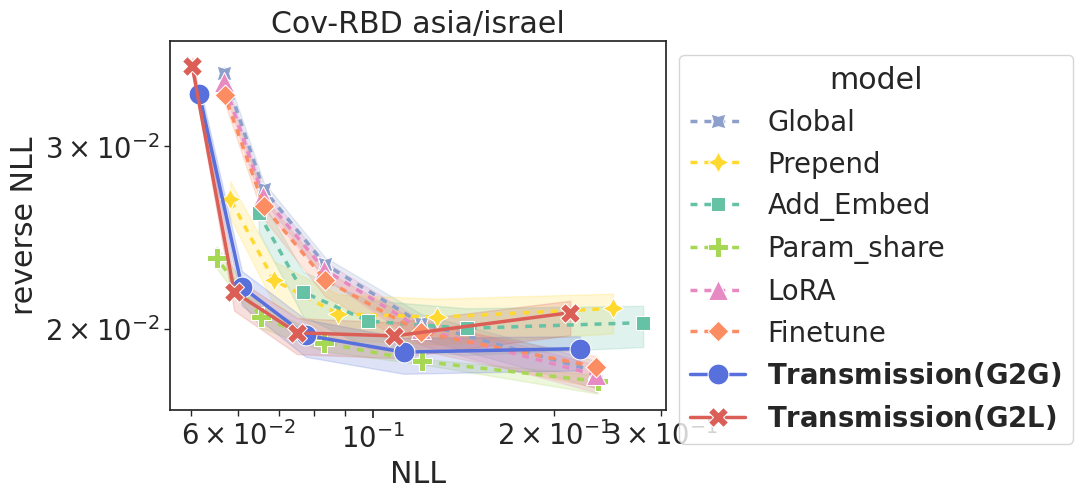

oceania/australia 118529
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


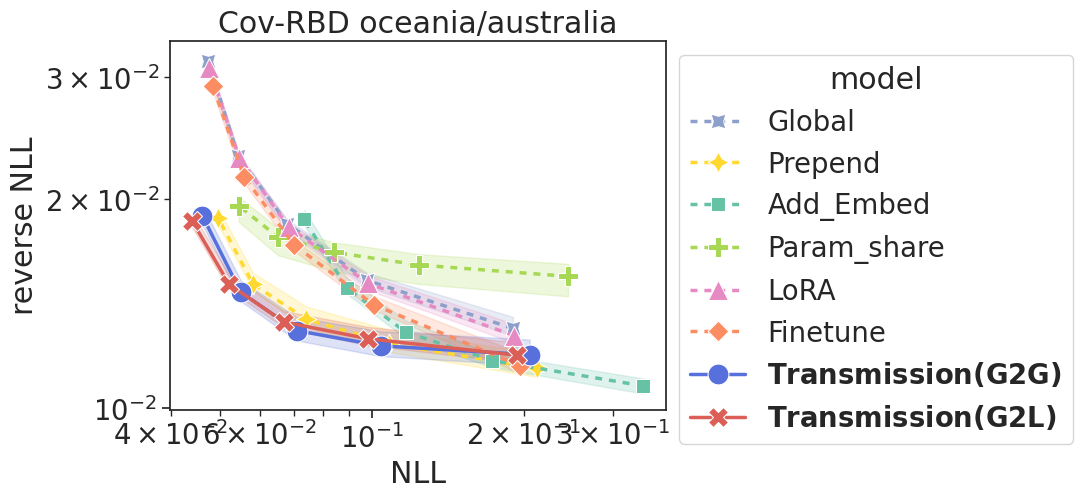

europe/austria 123227
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


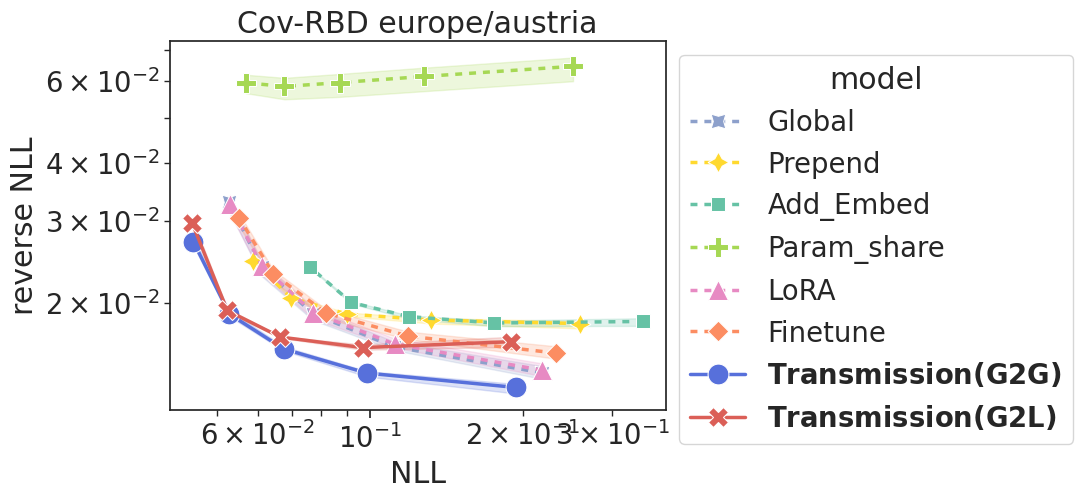

asia/india 133429
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


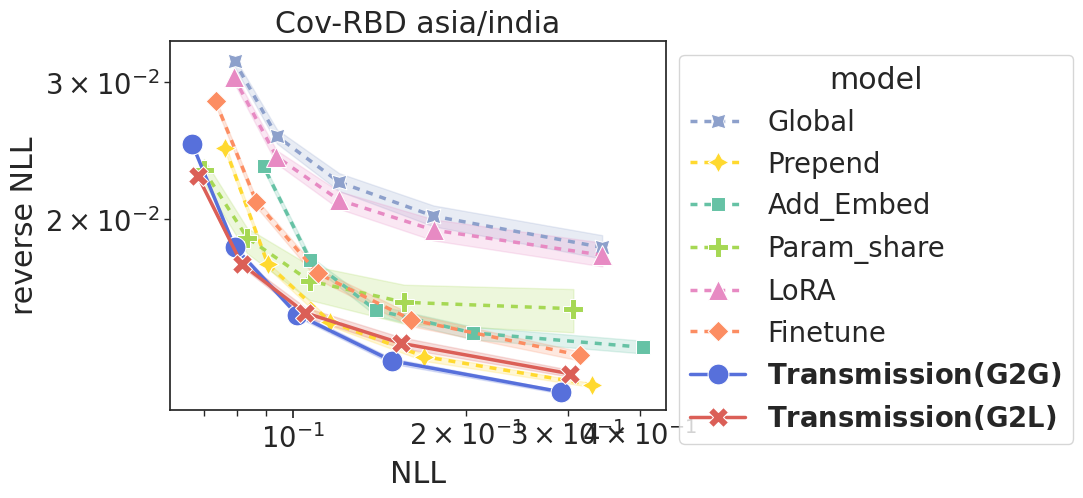

north_america/canada 241508
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


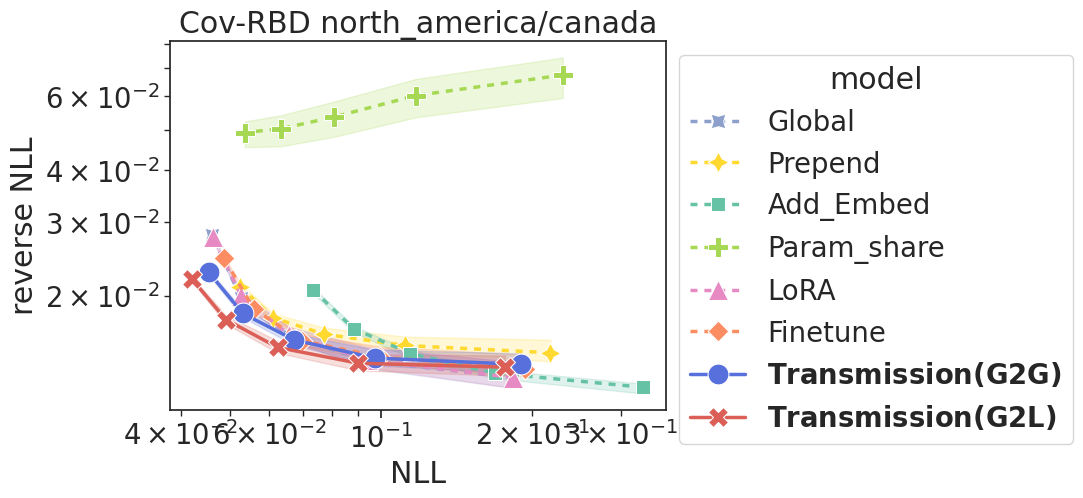

asia/japan 276091
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


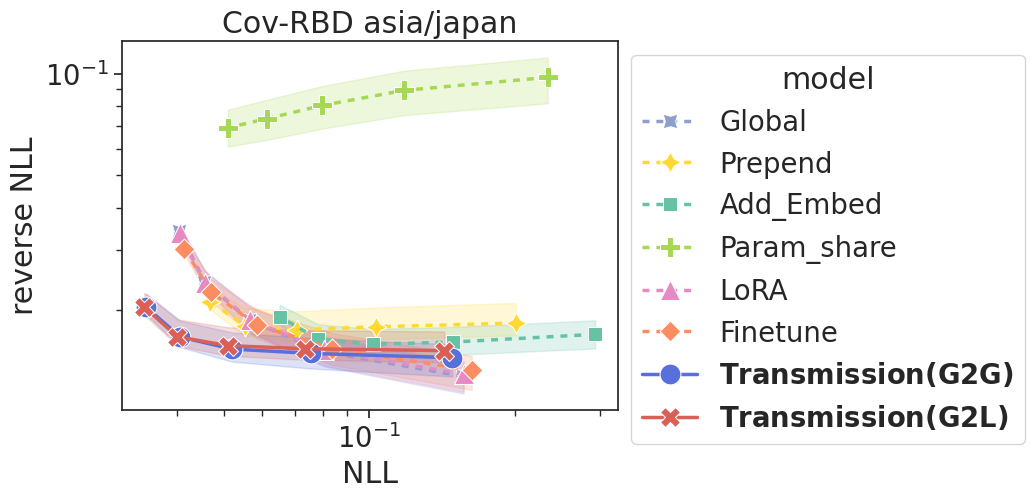

europe/france 370372
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


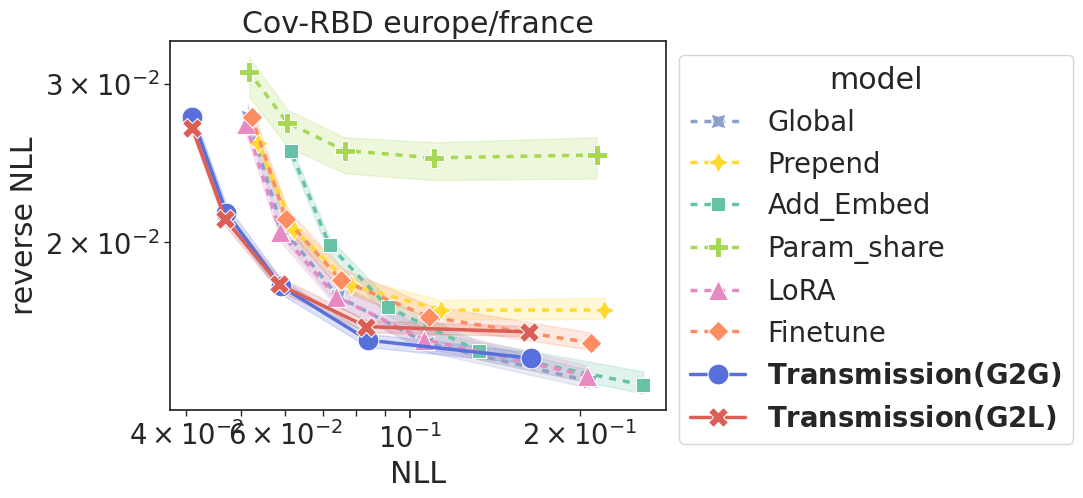

europe/denmark 413440
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


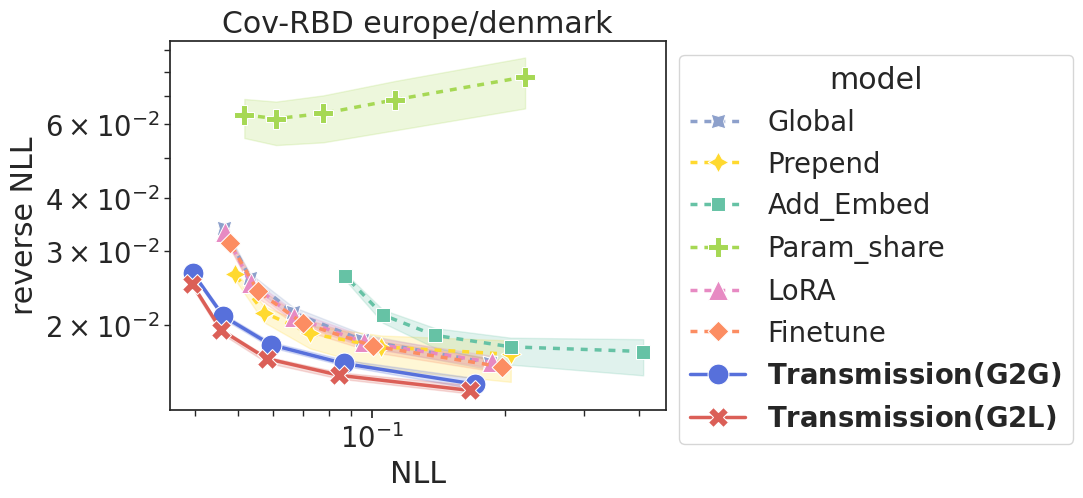

europe/germany 594760
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


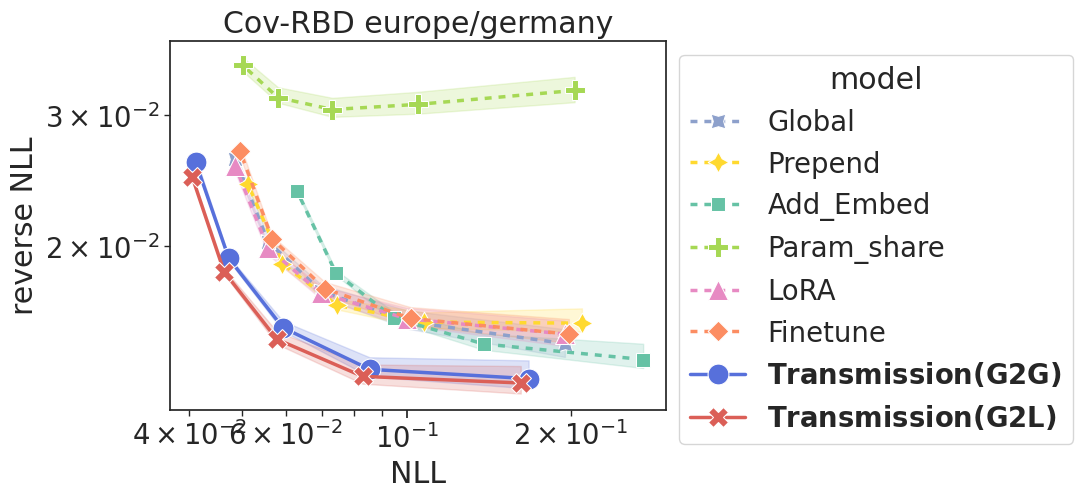

europe/united_kingdom 1830537
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


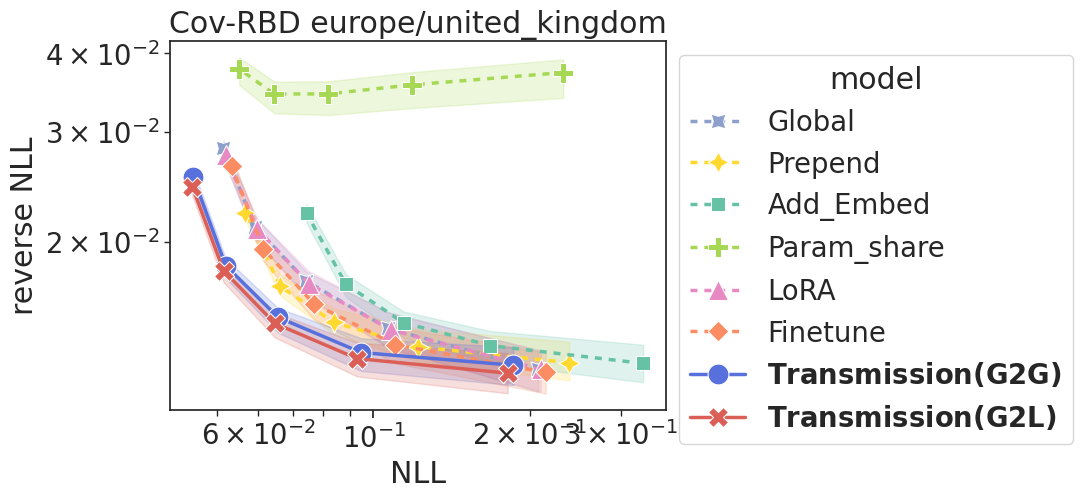

north_america/usa 2629373
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


/tmp/ipykernel_464456/2392183341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  summary_summary_df["model"] = [


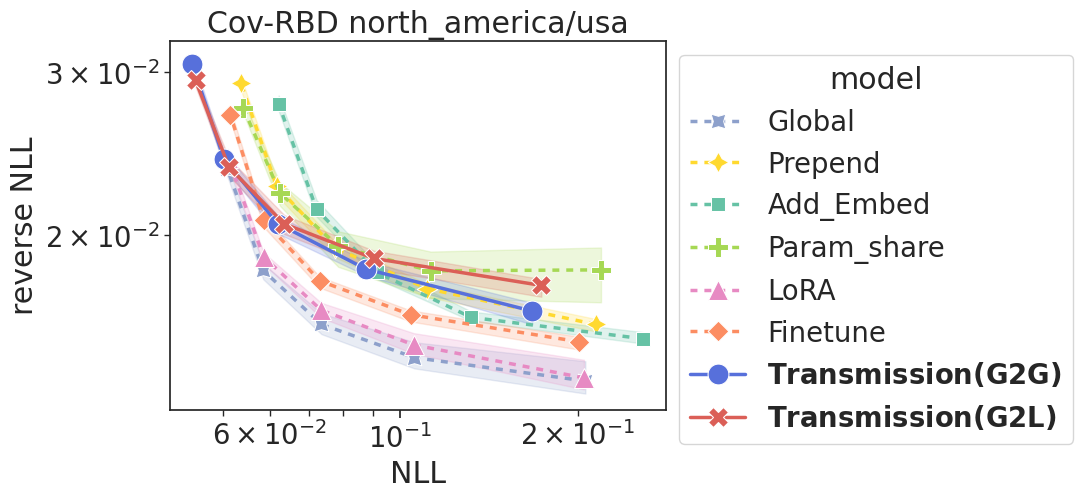

In [8]:
file_names = []
sorted_locations = sorted(dict(zip(local_summary_df["location"], local_summary_df["toal_sample_size"])).items(), key=lambda x: x[1])

for location, ss in sorted_locations:
    print(location, ss)
    local_df = local_summary_df[local_summary_df["location"] == location]
    if len(local_df) <= 0:
        continue
    
    plot(local_df, "Cov-RBD %s" % (location), 
         saving_dir / ("cov_country_%s.pdf" % location.replace("/", "_")))
    
    file_names.append("cov_country_%s.pdf" % location.replace("/", "_"))
    

['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


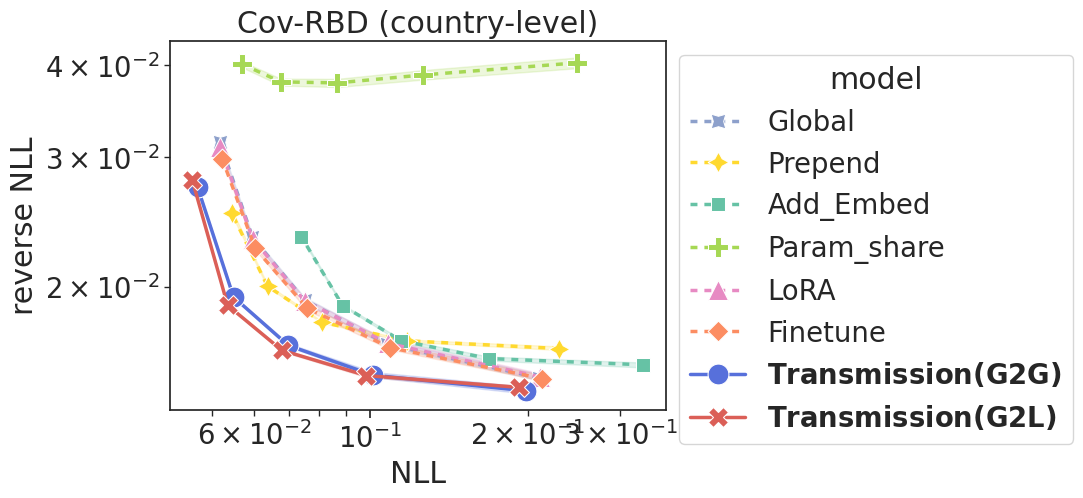

In [9]:
summary_summary_df = get_summary(nll_results[nll_results["bin_size"]>=min_bin_size], keys=("model", "temperature", "oracle"), weighted_average=False)

plot(summary_summary_df, "Cov-RBD (country-level)", 
         saving_dir / "main_res_cov_country_average.pdf")

In [10]:
def calculate_ci(data):
    # Calculate sample mean and standard deviation
    assert len(data) == 3
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)

    # Calculate the 95% confidence interval
    confidence = 0.95
    alpha = 1 - confidence

    # For large samples, use z-distribution
    z_critical = stats.norm.ppf(1 - alpha / 2)

    # Margin of error
    margin_of_error = z_critical * (std_dev / np.sqrt(n))
#     margin_of_error = t_critical * (std_dev / np.sqrt(n)) # Uncomment for small samples

    # Confidence interval
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    
    return mean, ci_lower, ci_upper
    

def print_markdown_table(df, temp, group_by=("model",), values=("rev_nll", 'nll')):
    res_dict = dict()
    for i, row in df.iterrows():
        key = tuple(row[x] for x in group_by)
        if key not in res_dict:
            res_dict[key] = defaultdict(list)
        for value in values:
            res_dict[key][value].append(row[value])    
    
    new_table = []
    rev_nll_cis = dict()
    for key in res_dict:
        ci = calculate_ci(res_dict[key]["rev_nll"])
        new_table.append(
            { 'model': key[0], 'nll': res_dict[key]["nll"][0], "rev_nll": ci[0], 'ci_lower': ci[1], 'ci_upper': ci[2]}
        )
        model_name = key[0].replace('_', '\\_')
        if model_name == "Transmission":
            model_name = "{\\bf Transmission}"
        x = f"{model_name} & {temperature} &  {res_dict[key]['nll'][0]:.4f} & {ci[0]:.4f} ({ci[1]:.4f}, {ci[2]:.4f}) \\\\"
        print(x)
        # print(key + " & " + res_dict[key]["NLL"][0] + " & " + "reverse NLL": ci[0] + " & " + "(%.3d)")
    
    
    df = pd.DataFrame(new_table)    
    return res_dict, rev_nll_cis

for temperature in (0.2, 0.4, 0.6, 0.8, 1.0):
    _, table = print_markdown_table(summary_summary_df[summary_summary_df["temperature"] == temperature], temperature)
    print("\midrule")

Global & 0.2 &  0.2103 & 0.0150 (0.0148, 0.0152) \\
Prepend & 0.2 &  0.2293 & 0.0165 (0.0164, 0.0166) \\
Add\_Embed & 0.2 &  0.3318 & 0.0157 (0.0155, 0.0158) \\
Param\_share & 0.2 &  0.2478 & 0.0403 (0.0396, 0.0411) \\
LoRA & 0.2 &  0.2104 & 0.0151 (0.0149, 0.0153) \\
Finetune & 0.2 &  0.2129 & 0.0150 (0.0148, 0.0152) \\
$\bf{Transmission(G2G)}$ & 0.2 &  0.1984 & 0.0144 (0.0142, 0.0146) \\
$\bf{Transmission(G2L)}$ & 0.2 &  0.1923 & 0.0146 (0.0145, 0.0147) \\
\midrule
Global & 0.4 &  0.1079 & 0.0167 (0.0165, 0.0169) \\
Prepend & 0.4 &  0.1173 & 0.0169 (0.0168, 0.0169) \\
Add\_Embed & 0.4 &  0.1682 & 0.0160 (0.0159, 0.0161) \\
Param\_share & 0.4 &  0.1261 & 0.0388 (0.0382, 0.0395) \\
LoRA & 0.4 &  0.1079 & 0.0167 (0.0166, 0.0169) \\
Finetune & 0.4 &  0.1092 & 0.0165 (0.0163, 0.0167) \\
$\bf{Transmission(G2G)}$ & 0.4 &  0.1013 & 0.0152 (0.0150, 0.0153) \\
$\bf{Transmission(G2L)}$ & 0.4 &  0.0983 & 0.0151 (0.0151, 0.0152) \\
\midrule
Global & 0.6 &  0.0749 & 0.0192 (0.0190, 0.0194) \\
Prep

['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Finetune', 'Global', 'LoRA', 'Param_share', 'Prepend']
{'$\\bf{Transmission(G2G)}$': '', '$\\bf{Transmission(G2L)}$': '', 'Add_Embed': (2, 2), 'Finetune': (2, 2), 'Global': (2, 2), 'LoRA': (2, 2), 'Param_share': (2, 2), 'Prepend': (2, 2)}
['$\\bf{Transmission(G2G)}$', '$\\bf{Transmission(G2L)}$', 'Add_Embed', 'Param_share', 'Finetune', 'Prepend', 'LoRA', 'Global']


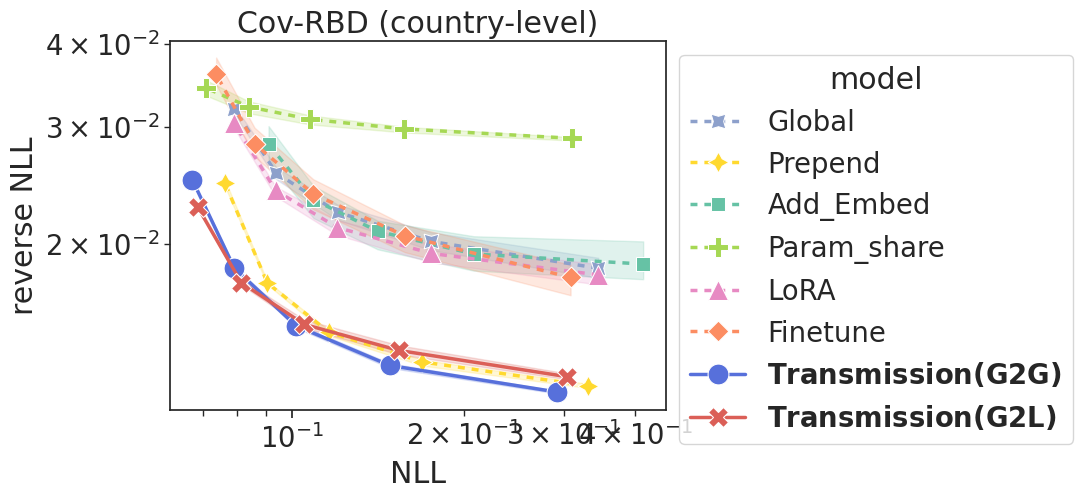

In [19]:
summary_summary_df = get_summary(nll_results[nll_results["bin_size"]>=min_bin_size], 
                                 keys=("model", "temperature", "oracle", "location"), weighted_average=False)

def get_worset_location(df, key="nll", temp=1.0):
    _df = df[df["temperature"] == temp]
    loc2nlls = defaultdict(list)

    for loc, nll in zip(_df["location"], _df["nll"]):
        loc2nlls[loc].append(nll)

    loc2nlls = {k: np.mean(v) for k, v in loc2nlls.items()}
    return sorted(loc2nlls.items(), key=lambda x: x[1], reverse=True)[0]
    

new_df = []
for model in ['Global', 'Prepend', 'Add_Embed', 'Param_share', 'LoRA', 'Finetune', 'Transmission(G2G)', 'Transmission(G2L)']:
    _df = summary_summary_df[summary_summary_df["model"] == model]
    location = get_worset_location(_df)[0]
    _df = _df[_df["location"] == location]
    new_df.append(_df)

new_df = pd.concat(new_df)

plot(new_df, "Cov-RBD (country-level)", 
         saving_dir / "main_res_cov_country_worse.pdf")